In [1]:
#============================================================================
#                           Importing Required Libraries
#============================================================================

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random
from sklearn.metrics import confusion_matrix

In [3]:
#============================================================================
#              Importing Data (with text as strings and not factors)
#============================================================================

adult_try_logistic = pd.read_csv("adult.csv")
type(adult_try_logistic)
adult_try_logistic.dtypes

Age                 int64
Workclass          object
Education          object
Educational-num     int64
Marital Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital Gain        int64
Capital Loss        int64
Hours per week      int64
Country            object
Income             object
dtype: object

In [6]:
#============================================================================
#              Replacing "?" with NA and Encoding Dependent Variable
#                  1 = Preferred Event | 0 = Alternate Event
#============================================================================

stack = adult_try_logistic.stack()
stack[stack == "?"] = None
adult_try_logistic = stack.unstack()

adult_try_logistic.Income[adult_try_logistic.Income == ">50K"] = 1
adult_try_logistic.Income[adult_try_logistic.Income == "<=50K"] = 0

In [14]:
#============================================================================
#                       Converting text to lower case
#============================================================================

adult_try_logistic.Workclass = adult_try_logistic.Workclass.str.lower()
adult_try_logistic.Occupation = adult_try_logistic.Occupation.str.lower()
adult_try_logistic.Education = adult_try_logistic.Education.str.lower()
adult_try_logistic.Race = adult_try_logistic.Race.str.lower()
adult_try_logistic.Sex = adult_try_logistic.Sex.str.lower()
adult_try_logistic['Country'] = adult_try_logistic['Country'].str.lower()
adult_try_logistic['Marital Status'] = adult_try_logistic['Marital Status'].str.lower()
adult_try_logistic.Relationship = adult_try_logistic.Relationship.str.lower()


In [15]:
#=============================================================================
#                      Checking for % of Missing Values
# Decide whether to impute or not. If yes, with or without category wise median / mean / mode
#                        If not, encode Missing Values
#=============================================================================

pd.isna(adult_try_logistic).mean() # gives col wise %age
type(adult_try_logistic)
adult_try_logistic.dtypes

Age                object
Workclass          object
Education          object
Educational-num    object
Marital Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital Gain       object
Capital Loss       object
Hours per week     object
Country            object
Income             object
dtype: object

In [17]:
#=============================================================================
#                          Check for Imbalanced Data
#=============================================================================
adult_try_logistic.Income.value_counts()

Income
0    37155
1    11687
Name: count, dtype: int64

In [19]:
#=============================================================================
#                          Missing Value Replacement
#=============================================================================

adult_try_logistic.Workclass[pd.isna(adult_try_logistic.Workclass)]= "missing_workclass"
adult_try_logistic.Occupation[pd.isna(adult_try_logistic.Occupation)]= "missing_occupation"
adult_try_logistic['Country'][pd.isna(adult_try_logistic['Country'])]= "missing_country"

In [30]:
#=============================================================================
#                          Converting back to Categorical Variables
#=============================================================================
adult_try_logistic.Workclass = adult_try_logistic.Workclass.astype('category')
adult_try_logistic.Occupation = adult_try_logistic.Occupation.astype('category')
adult_try_logistic['Country'] = adult_try_logistic['Country'].astype('category')
adult_try_logistic.Race = adult_try_logistic.Race.astype('category')
adult_try_logistic.Sex = adult_try_logistic.Sex.astype('category')
adult_try_logistic.Relationship = adult_try_logistic.Relationship.astype('category')
adult_try_logistic.Income = adult_try_logistic.Income.astype('category')
adult_try_logistic.Education = adult_try_logistic.Education.astype('category')
adult_try_logistic['Marital Status'] = adult_try_logistic['Marital Status'].astype('category')
adult_try_logistic.dtypes


Age                  object
Workclass          category
Education          category
Educational-num      object
Marital Status     category
Occupation         category
Relationship       category
Race               category
Sex                category
Capital Gain         object
Capital Loss         object
Hours per week       object
Country            category
Income             category
dtype: object

In [35]:

#=============================================================================
#                         Check Information Value (IV)
#=============================================================================
def iv_woe(data, target, bins=10, show_woe=False):

    # Empty DataFrame
    newDF = pd.DataFrame()

    # Extract Column Names
    cols = data.columns

    # Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars])) > 10):
            binned_x = pd.qcut(data[ivars], bins, duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        
        # Handle categorical target variable
        if d0['y'].dtype.name == 'category':
            d0['y'] = d0['y'].cat.codes
        
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = d['Events'] / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = d['Non-Events'] / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events'] / d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(), 6)))
        temp = pd.DataFrame({"Variable": [ivars], "IV": [d['IV'].sum()]}, columns=["Variable", "IV"])
        newDF = pd.concat([newDF, temp], axis=0)

        # Show WOE Table
        if show_woe:
            print(d)
    return newDF

# Example usage
IV_Table = iv_woe(data=adult_try_logistic, target='Income', bins=2, show_woe=True)


Information value of Age is inf
   Cutoff     N  Events  % of Events  Non-Events  % of Non-Events       WoE  \
0      17   595       0     0.000000         595         0.016014      -inf   
1      18   862       0     0.000000         862         0.023200      -inf   
2      19  1053       3     0.000257        1050         0.028260 -4.701312   
3      20  1113       1     0.000086        1112         0.029929 -5.857294   
4      21  1096       6     0.000513        1090         0.029337 -4.045552   
..    ...   ...     ...          ...         ...              ...       ...   
69     86     1       0     0.000000           1         0.000027      -inf   
70     87     3       0     0.000000           3         0.000081      -inf   
71     88     6       1     0.000086           5         0.000135 -0.452817   
72     89     2       0     0.000000           2         0.000054      -inf   
73     90    55      13     0.001112          42         0.001130 -0.016099   

              IV  


/Users/weicheng/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/weicheng/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/weicheng/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/weicheng/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/weicheng/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/weicheng/anaconda3/lib/python3.11/site-packages/panda

In [53]:

#============================================================================
#                             Thumb Rule for IV
#============================================================================
#Information Value	Predictive Power
#< 0.02	useless for prediction
#0.02 to 0.1	Weak predictor
#0.1 to 0.3	Medium predictor
#0.3 to 0.5	Strong predictor
#>0.5	Suspicious or too good to be true

#============================================================================
#                             Weight of Evidence
#============================================================================

def calculate_woe_iv(df, feature, target):
    """
    Calculate Weight of Evidence (WoE) and Information Value (IV) for a categorical feature.

    Parameters:
    - df: DataFrame containing the data.
    - feature: The name of the categorical feature for which to calculate WoE and IV.
    - target: The name of the target variable.

    Returns:
    - DataFrame with WoE and IV for each category of the feature.
    """
    # Calculate the total events and non-events
    total_events = df[target].sum()
    total_non_events = df[target].count() - total_events

    # Group by feature and calculate the necessary statistics
    grouped = df.groupby(feature)
    stats = grouped[target].agg(['count', 'sum'])
    stats.columns = ['Total', 'Events']

    # Calculate non-events
    stats['Non-Events'] = stats['Total'] - stats['Events']

    # Calculate the event and non-event rate
    stats['Event Rate'] = stats['Events'] / total_events
    stats['Non-Event Rate'] = stats['Non-Events'] / total_non_events

    # Calculate WoE
    stats['WoE'] = np.log(stats['Event Rate'] / stats['Non-Event Rate'])

    # Handle cases where the calculation might result in division by zero or log of zero
    stats['WoE'] = stats['WoE'].replace([np.inf, -np.inf], 0)
    stats['WoE'] = stats['WoE'].fillna(0)

    # Calculate IV
    stats['IV'] = (stats['Event Rate'] - stats['Non-Event Rate']) * stats['WoE']

    return stats[['WoE', 'IV']]

# Example usage
# Ensure newDF is your DataFrame, "Occupation" is the feature, and replace 'your_target_column_name' with your actual target column name
IV_Table = iv_woe(data=adult_try_logistic, target='Income', bins=2, show_woe=True)

woe_iv_table = calculate_woe_iv(newDF, 'Occupation', 'Income')
print(woe_iv_table)

Information value of Age is 0.361143
           Cutoff      N  Events  % of Events  Non-Events  % of Non-Events  \
0  (16.999, 37.0]  24974    3370     0.288355       21604         0.581456   
1    (37.0, 90.0]  23868    8317     0.711645       15551         0.418544   

        WoE        IV  
0 -0.701344  0.205565  
1  0.530798  0.155578  
Information value of Workclass is inf
              Cutoff      N  Events  % of Events  Non-Events  % of Non-Events  \
0        federal-gov   1432     561     0.048002         871         0.023442   
1          local-gov   3136     927     0.079319        2209         0.059454   
2  missing_workclass   2799     265     0.022675        2534         0.068201   
3       never-worked     10       0     0.000000          10         0.000269   
4            private  33906    7387     0.632070       26519         0.713740   
5       self-emp-inc   1695     938     0.080260         757         0.020374   
6   self-emp-not-inc   3862    1077     0.092154   

/Users/weicheng/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


NameError: name 'newDF' is not defined

In [42]:

#=============================================================================
#                      Choosing Relevant Independent Variables
#=============================================================================

adult_try_logistic = adult_try_logistic.drop(axis=1,columns=['Sex','Capital Loss','Country'])


In [47]:

#============================================================================
#                           Create Training Data (Bootstrapping)
#============================================================================
adult_try_logistic = adult_try_logistic.rename(columns={"hours-per-week":"hours_per_week"})
adult_try_logistic.Age = adult_try_logistic.Age.astype('int')
adult_try_logistic['Educational-num'] = adult_try_logistic['Educational-num'].astype('int')
adult_try_logistic['Capital Gain'] = adult_try_logistic['Capital Gain'].astype('int')
adult_try_logistic['Hours per week'] = adult_try_logistic['Hours per week'].astype('int')


input_ones = adult_try_logistic[adult_try_logistic.Income == 1]  # all 1's code (encoding) of whichever level is lower in frequency
input_zeroes = adult_try_logistic[adult_try_logistic.Income == 0]  # all 0's
random.seed(100)
training_ones = input_ones.sample(frac=0.7)
training_zeroes = input_zeroes.sample(frac=0.7)
trainingData = pd.concat([training_ones,training_zeroes])

In [48]:
#===========================================================================
#                               Create Test Data
#===========================================================================
test_ones = input_ones.loc[~input_ones.index.isin(training_ones.index)]
test_zeroes = input_zeroes.loc[~input_zeroes.index.isin(training_zeroes.index)]
testData = pd.concat([test_ones,test_zeroes])  # row bind the 1's and 0's

In [57]:
#===========================================================================
#                      Modeling (Tuning based on p-values)
#                  Number of Fisher Iterations should be less
#===========================================================================
logitMod = smf.glm("Income ~ Age + C(Workclass) + C(Education) + C(Occupation) + Q('Hours per week')", data=trainingData, family=sm.families.Binomial()).fit()

logitMod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Generalized Linear Model Regression Results                      
======================================================================================
Dep. Variable:     ['Income[0]', 'Income[1]']   No. Observations:                34189
Model:                                    GLM   Df Residuals:                    34150
Model Family:                        Binomial   Df Model:                           38
Link Function:                          Logit   Scale:                          1.0000
Method:                                  IRLS   Log-Likelihood:                -14526.
Date:                        Wed, 06 Mar 2024   Deviance:                       29053.
Time:                                21:07:50   Pearson chi2:                 3.24e+04
No. Iterations:                            21   Pseudo R-squ. (CS):             0.2218
Covariance Type:                    nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               5.9317      0.183     32.351      0.000       5.572       6.291
C(Workclass)[T.local-gov]               0.6984      0.093      7.496      0.000       0.516       0.881
C(Workclass)[T.missing_workclass]      -5.8769   5734.664     -0.001      0.999   -1.12e+04    1.12e+04
C(Workclass)[T.never-worked]           12.6154   1.15e+04      0.001      0.999   -2.25e+04    2.25e+04
C(Workclass)[T.private]                 0.4854      0.077      6.297      0.000       0.334       0.636
C(Workclass)[T.self-emp-inc]           -0.0178      0.102     -0.174      0.862      -0.219       0.183
C(Workclass)[T.self-emp-not-inc]        0.8389      0.092      9.167      0.000       0.660       1.018
C(Workclass)[T.state-gov]               0.8884      0.104      8.583      0.000       0.685       1.091
C(Workclass)[T.without-pay]             0.8947      0.791      1.132      0.258      -0.655       2.444
C(Education)[T.11th]                   -0.1067      0.192     -0.556      0.578      -0.483       0.269
C(Education)[T.12th]                   -0.3388      0.237     -1.428      0.153      -0.804       0.126
C(Education)[T.1st-4th]                 0.9722      0.481      2.021      0.043       0.029       1.915
C(Education)[T.5th-6th]                 0.1664      0.279      0.596      0.551      -0.381       0.714
C(Education)[T.7th-8th]                 0.2141      0.210      1.018      0.309      -0.198       0.627
C(Education)[T.9th]                     0.0503      0.233      0.216      0.829      -0.407       0.507
C(Education)[T.assoc-acdm]             -1.5209      0.158     -9.657      0.000      -1.830      -1.212
C(Education)[T.assoc-voc]              -1.4868      0.153     -9.705      0.000      -1.787      -1.187
C(Education)[T.bachelors]              -2.0318      0.143    -14.205      0.000      -2.312      -1.751
C(Education)[T.doctorate]              -2.9340      0.184    -15.918      0.000      -3.295      -2.573
C(Education)[T.hs-grad]                -0.9560      0.141     -6.801      0.000      -1.231      -0.680
C(Education)[T.masters]                -2.2983      0.150    -15.342      0.000      -2.592      -2.005
C(Education)[T.preschool]               1.2898      1.047      1.232      0.218      -0.763       3.342
C(Education)[T.prof-school]            -3.1160      0.177    -17.633      0.000      -3.462      -2.770
C(Education)[T.some-college]           -1.2510      0.142     -8.801      0.000      -1.530      -0.972
C(Occupation)[T.armed-forces]          -0.1143      0.870     -0.131      0.896      -1.820       1.591
C(Occupation)[T.craft-repair]          -0.7724      0.064    -12.129      0.000    

In [59]:
#===========================================================================
#                            Testing (Prediction)
#===========================================================================

predicted = logitMod.predict(testData[['Age','Workclass','Education','Occupation','Hours per week']])


Area under the ROC curve : 0.177165
           fpr       tpr     1-fpr        tf  thresholds
2705  0.742352  0.257558  0.257648 -0.000089    0.747757


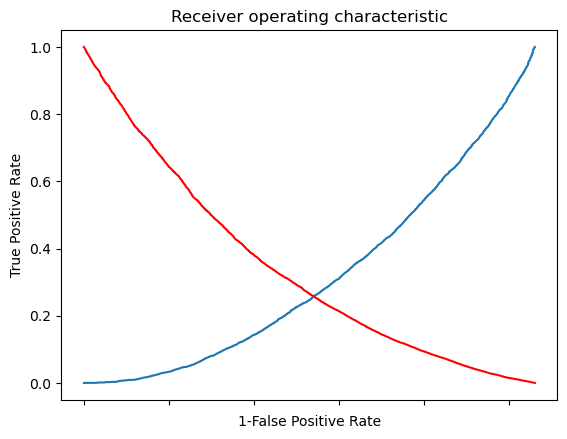

In [62]:
#===========================================================================
#                          Deciding Optimal Cut-off
#===========================================================================

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds =roc_curve(testData.Income, predicted)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})

# Threshold
optCutOff = roc.loc[(roc.tf-0).abs().argsort()[:1]]
print(optCutOff)


# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])
plt.show()

In [63]:

#============================================================================
#                        Checking Accuracy of the Model
#============================================================================

fitted_results = predicted
for k in fitted_results.index:
    print(k)
    if fitted_results[k] >= optCutOff['thresholds'].values:
        fitted_results[k]=1
    else:
        fitted_results[k]=0

misClasificError = np.mean(fitted_results != testData.income)
print('Accuracy',1-misClasificError)


7
11
14
84
94
96
111
125
164
197
214
238
240
246
250
265
281
285
342
352
363
372
408
453
470
519
520
523
533
561
564
593
597
632
652
659
665
667
673
696
739
745
750
784
807
808
837
842
857
872
881
883
894
934
956
958
968
977
993
995
1021
1043
1049
1052
1053
1058
1064
1066
1073
1079
1083
1090
1098
1104
1111
1115
1118
1137
1149
1156
1162
1166
1180
1201
1224
1243
1250
1257
1261
1275
1276
1281
1286
1322
1324
1337
1350
1351
1355
1387
1412
1432
1437
1444
1453
1459
1462
1481
1482
1512
1516
1571
1585
1593
1611
1612
1627
1635
1642
1645
1648
1654
1666
1676
1693
1695
1723
1735
1738
1740
1795
1811
1812
1819
1869
1881
1887
1895
1915
1922
1933
1938
1959
1961
1963
1972
1975
1998
2026
2056
2066
2073
2074
2081
2090
2093
2103
2106
2109
2110
2157
2160
2164
2179
2227
2233
2237
2240
2249
2252
2287
2305
2308
2325
2330
2348
2385
2426
2430
2431
2460
2462
2465
2469
2505
2508
2514
2560
2576
2580
2583
2598
2607
2620
2624
2631
2660
2663
2665
2716
2719
2724
2725
2738
2744
2767
2774
2783
2832
2840
2844
2874
2919
29

AttributeError: 'DataFrame' object has no attribute 'income'

In [67]:
#============================================================================
#                               Confusion Matrix
#============================================================================

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

results = confusion_matrix(testData.Income, fitted_results)
print('Confusion Matrix :')
print(results)
print('Accuracy Score :',accuracy_score(testData.Income, fitted_results))
print('Report : ')
print(classification_report(testData.Income, fitted_results))

tn, fp, fn, tp = results.ravel()


Confusion Matrix :
[[2872 8275]
 [2603  903]]
Accuracy Score : 0.2576264246229441
Report : 
              precision    recall  f1-score   support

           0       0.52      0.26      0.35     11147
           1       0.10      0.26      0.14      3506

    accuracy                           0.26     14653
   macro avg       0.31      0.26      0.24     14653
weighted avg       0.42      0.26      0.30     14653



In [68]:
#============================================================================
#                                Sensitivity
#============================================================================
print(tp/(tp+fn))


0.25755847119224184


In [69]:
#============================================================================
#                                Specificity
#============================================================================
print(tn/(tn+fp))

0.2576477976137077
